In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(1, '/cluster/home/omineeva/ResMiCo')
from resmico import utils
from pathlib import Path

2022-01-14 17:25:06.445336: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import average_precision_score, recall_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import time

In [4]:
project_path = '/cluster/home/omineeva/global_projects/projects/projects2019-contig_quality/'
gut_path = project_path+'data/CAMI/CAMI2_HMP-gut/short_read/ResMiCo-SM/'
skin_path = project_path+'data/CAMI/CAMI2_HMP-skin/short_read/ResMiCo-SM/'
oral_path = project_path+'data/CAMI/CAMI2_HMP-oral/short_read/ResMiCo-SM/'

predictions_path=project_path+'/Outputs/predictions/'
save_path = project_path+'Outputs/'

In [25]:
def creat_dfs(site):
    gut_path = project_path+'data/CAMI/CAMI2_HMP-gut/short_read/ResMiCo-SM/'
    skin_path = project_path+'data/CAMI/CAMI2_HMP-skin/short_read/ResMiCo-SM/'
    oral_path = project_path+'data/CAMI/CAMI2_HMP-oral/short_read/ResMiCo-SM/'
    
    if site == 'gut':
        site_path = gut_path
        deepmased_df = pd.read_csv(project_path+'Outputs/predictions/CAMI2_HMP_gut_v1.csv')
        resmico_df = pd.read_csv('') #TODO
    elif site == 'skin':
        site_path = skin_path
        deepmased_df = pd.read_csv(project_path+'Outputs/predictions/CAMI2_HMP_skin_v1.csv')
        resmico_df = pd.read_csv('/cluster/home/ddanciu/tmp/evaluate_skin_2022-01-11_10-19-47.csv')
    elif site == 'oral':
        site_path = oral_path
        deepmased_df = pd.read_csv(project_path+'Outputs/predictions/CAMI2_HMP_oral_v1.csv')
        resmico_df = pd.read_csv('') #TODO
        
    ALE_path = site_path+'ALE/'
    ALE_df = pd.read_csv(ALE_path + 'aggregated_preds.csv')
    
    metaMIC_path = site_path+'metaMIC/'
    metaMIC_df = load_metamic(metaMIC_path)
    
    n=7
    resmico_df['cont_name']=resmico_df['cont_name'].map(lambda x: '/'.join(x.split('/')[-n:]))
    resmico_df = resmico_df.rename(columns={"max": "resmico_score"})
    deepmased_df = deepmased_df.rename(columns={"max": "deepmased_score"})
    deepmased_df = deepmased_df.drop(columns = ['length', 'label']) 
    metaMIC_df = metaMIC_df.drop(columns = ['length'])
    print(site, len(resmico_df), len(deepmased_df), len(metaMIC_df), len(ALE_df))
    
    result = pd.merge(resmico_df, deepmased_df, on=['cont_name'])
    print('result',len(result))
    result = pd.merge(result, ALE_df, on=['cont_name'])
    print('result',len(result))

    result_m = pd.merge(result, metaMIC_df, on=['cont_name'])
    print('result_m', len(result), len(result_m))
    
    print('AUPRC resmico_score: ',
      average_precision_score(result['label']>0, result['resmico_score']))
    print('AUPRC deepmased_score: ',
      average_precision_score(result['label']>0, result['deepmased_score']))
    print('AUPRC ALE_score: ',
          average_precision_score(result['label']>0, result['ALE_score']))
    print('RANDOME score: ',
          np.mean(result['label']))
    
    print('/n metamic subset:')
    print('AUPRC metaMIC: ',
          average_precision_score(result_m['label']>0, result_m['metaMIC_contig_score']))
    print('AUPRC resmico_score: ',
      average_precision_score(result_m['label']>0, result_m['resmico_score']))
    print('AUPRC deepmased_score: ',
      average_precision_score(result_m['label']>0, result_m['deepmased_score']))
    print('AUPRC ALE_score: ',
          average_precision_score(result_m['label']>0, result_m['ALE_score']))
    print('RANDOME score: ',
          np.mean(result_m['label']))
    
    return result, result_m

In [23]:
def PR4all(axs, i, df, df_m,
           dataset_name = 'dname', save_path=None):
    ax = axs[i]
    y_true_r, y_resmico = df.label>0, df.resmico_score
    y_true_d, y_deepmased = df.label>0, df.deepmased_score
    y_true_a, y_ALE = df.label>0, df.ALE_score
    y_true_m, y_metaMIC = df_m.label>0, df_m.metaMIC_contig_score
    
    colors = [(0, 160/255, 81/255), (28/255, 117/255, 188/255), (46/255, 49/255, 14/255), (236/255, 0, 140/255)]
    linestyles = ['solid','dashed']

    # resmico
    prs, rcs, thresholds = precision_recall_curve(y_true_r, y_resmico)
    re = ax.plot(rcs, prs, lw=1.5, color=colors[0], ls=linestyles[0],
                 label='ResMiCo: %0.3f' % (average_precision_score(y_true_r, y_resmico)))
    
    # deepmased
    prs, rcs, thresholds = precision_recall_curve(y_true_d, y_deepmased)
    d = ax.plot(rcs, prs, lw=1.5, color=colors[1], ls=linestyles[0],
                 label='DeepMAsED: %0.3f' % (average_precision_score(y_true_d, y_deepmased)))
        
    # ALE
    prs, rcs, thresholds = precision_recall_curve(y_true_a, y_ALE)
    a =ax.plot(rcs, prs, lw=1.5, color=colors[2], ls=linestyles[0],
                 label='ALE: %0.3f' % (average_precision_score(y_true_a, y_ALE)))
    
    
    # metaMIC
    prs, rcs, thresholds = precision_recall_curve(y_true_m, y_metaMIC)
    m = ax.plot(rcs, prs, lw=1.5, color=colors[3], ls=linestyles[0],
                 label='metaMIC: %0.3f' % (average_precision_score(y_true_m, y_metaMIC)))
        
    # Random
    pr_random = np.mean(y_true_r)
    ra = ax.plot([0, 1], [pr_random, pr_random], color='black', ls=linestyles[1], label="Random: %0.3f" % pr_random, lw=2)


    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    
    # plt.title('Receiver operating characteristic example')
#     if i==1:
#         ax.legend(bbox_to_anchor=(0.5, 1.4), loc='upper center', 
#                   ncol=5, fontsize=26)
    if i==0:
        ax.set_ylabel('Precision', fontsize=16)
    ax.set_xlabel('Recall', fontsize=16)
    
    ax.legend(fontsize=16)
    ax.grid(True, axis='y', linestyle=':')
    ax.grid(True, axis='x', linestyle=':')
    
    ax.set_title('skin', fontsize=16)

    return 

skin 323396 323378 283605 323396
result 323378
result 323378
result_m 323378 283587
AUPRC resmico_score:  0.5791368348810135
AUPRC deepmased_score:  0.04212492697960772
AUPRC ALE_score:  0.05085155177442041
RANDOME score:  0.018380965928418137
/n metamic subset:
AUPRC metaMIC:  0.1033062720625168
AUPRC resmico_score:  0.5361645808516742
AUPRC deepmased_score:  0.036859364423680346
AUPRC ALE_score:  0.04724137841319416
RANDOME score:  0.01758895859119071
/cluster/home/omineeva/global_projects/projects/projects2019-contig_quality/Outputs/figures/PRcurve_cami.pdf


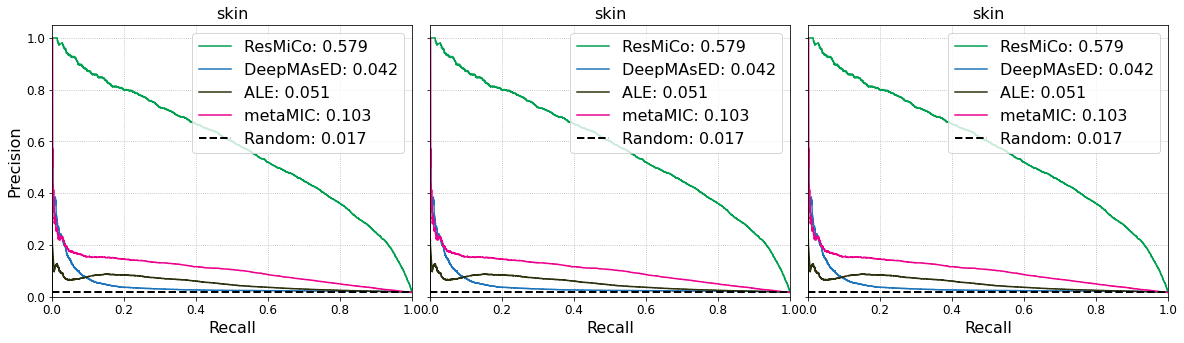

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey = True)
fig.subplots_adjust(wspace=0.05)
df, result_m = creat_dfs('skin')
PR4all(axs, 0,  df, result_m)
df, result_m = creat_dfs('skin')
PR4all(axs, 1, df, result_m)
df, result_m = creat_dfs('skin')
PR4all(axs, 2, df, result_m)

dataset_name = 'cami'
if save_path:
    where = save_path+'figures/PRcurve_'+dataset_name+'.pdf'
    plt.savefig(where, 
                bbox_inches='tight', format='pdf', dpi=300)
    print(where)

plt.show()

In [6]:
#Aggregate ALE

In [10]:
# import gzip
# import _pickle as pickle
# def create_ALE_pickle(assembly_path):
#     parsed_ale = {}

#     with gzip.open(assembly_path, 'rt') as gf: #open
#         cur_contig, cont_length = None, None
#         ti = time.time()
#         for i, g in enumerate(gf):
#             line = g.split()

#             if 'Reference' in line[1]:
#                 # Sanity check
#                 if not (cont_length  is None): 
#                     assert((parsed_ale[cur_contig]['depth'] < 10 ** 5).all())

#                 cur_contig = line[2]
#                 cont_length = int(line[3])

#                 base = 10 ** 5 * np.ones(cont_length)

#                 parsed_ale[cur_contig] = {'depth' : base.copy(), 'place' : base.copy(), 
#                                          'insert' : base.copy(), 'kmer' : base.copy()}

#                 next(gf)
#                 idx = 0
#                 continue

#             if cur_contig is None:
#                 continue

#             parsed_ale[cur_contig]['depth'][idx] = float(line[3])
#             parsed_ale[cur_contig]['place'][idx] = float(line[4])
#             parsed_ale[cur_contig]['insert'][idx] = float(line[5])
#             parsed_ale[cur_contig]['kmer'][idx] = float(line[6])
#             idx += 1


#     save_path = assembly_path.replace('.txt.gz', '_all.pkl') 
#     print (time.time()-ti, save_path)
#     with open(save_path, 'wb') as f:
#         pickle.dump(parsed_ale, f)

In [29]:
# for site in [oral_path, gut_path, skin_path]:
#     ALE_path = site+'ALE/'
#     EXT = ".txt.gz"
#     all_txt_files = []
#     for r, d, f in os.walk(ALE_path):
#         for file in f:
#             if EXT in file:
#                 all_txt_files.append(os.path.join(r,file))

#     import pathos
#     nprocs = 16
#     with pathos.multiprocessing.Pool(nprocs) as pool:
#         pool.map(lambda file: create_ALE_pickle(file), all_txt_files)

In [30]:
# #synthetic
# def aggregate_ALE(ALE_path):
#     st = time.time()
#     thresh = {'depth': -21,
#               'place' : -2,
#               'insert' : 2,
#               'kmer' : 2}
#     all_preds = {'ALE_score':[],
#                 'cont_name':[]}

#     EXT = '.pkl'
#     all_pkl_files = []
#     for r, d, f in os.walk(ALE_path):
#         for file in f:
#             if EXT in file:
#                 all_pkl_files.append(os.path.join(r,file))

#     for i, file in enumerate(all_pkl_files): 
#         print(i)
#         with open(file, 'rb') as f:
#             ale_scores = pickle.load(f)

#             for cont in ale_scores:
#                 total = 0
#                 for score in ale_scores[cont]:
#                     total += np.sum(ale_scores[cont][score] < thresh[score])

#                 all_preds['ALE_score'].append(total / float(len(thresh)) / len(ale_scores[cont]['depth']))
#                 cont_name = '/'.join(file.split('/')[-7:-1])+'/'+cont
#                 all_preds['cont_name'].append(cont_name)

#     ALE_preds = pd.DataFrame.from_dict(all_preds)
#     ALE_preds.to_csv(ALE_path + 'aggregated_preds.csv', index=False) 
#     print('saved as: '+ ALE_path + 'aggregated_preds.csv')


# for site in [oral_path, gut_path, skin_path]:
#     ALE_path = site+'ALE/'
#     aggregate_ALE(ALE_path)